In [1]:
import torch
import torch.nn as nn
DIM = 10
w = torch.empty(DIM)
torch.nn.init.uniform_(w,a=-2.0,b=2.0)

def f(x): #定义要优化的函数，参数为x，输入数据为w
    x= w*(x-1)
    return (x*x).sum()

#def f_x(x,w): #预测的x->y的映射函数，用一个5x5的矩阵w来表示参数
#    return w*x**2

#def label(x): #要学习 的实际函数
#    return  x**2

定义我们常用的优化器SGD,RMSProp,Adam
RMSProp根据当前时刻下，当前梯度和历史梯度的平方加权和（越老的历史梯度，其权重越低）来重新调节学习率(历史梯度越低，那么学习率越大，历史梯度越高，那么学习率越大)，来加快收敛。
Adam是RMSProp的变体，即通过估计当前梯度的一阶矩估计和二阶矩估计来代替，梯度和梯度的平方，然后更新策略和RMSProp一样。

In [2]:
def SGD(gradients, state, learning_rate=0.05):
   
    return -gradients*learning_rate, state

def RMS(gradients, state, learning_rate=0.05, decay_rate=0.9):
    if state is None:
        state = torch.zeros(DIM)
    
    state = decay_rate*state + (1-decay_rate)*torch.pow(gradients, 2)
    update = -learning_rate*gradients / (torch.sqrt(state)+1e-5)
    return update, state



这里的Adam优化器直接用了Pytorch里定义的。

In [3]:
def Adam(gradients, state, learning_rate=0.05, decay_rate=0.9):
    return torch.optim.Adam()

In [6]:
TRAINING_STEPS = 40

def learn(optimizer):
    x = torch.empty(DIM)
    torch.nn.init.uniform_(x,a=-2.0,b=2.0) 
    x = torch.tensor(x,dtype=torch.float32,requires_grad=True)
    
    state = None
    if optimizer.__name__ !='Adam':
        losses = []
        for i in range(TRAINING_STEPS):
            x.requires_grad = True

            loss = f(x)
            loss.backward()

            update, state = optimizer(x, state)
            losses.append(loss.detach_())
            x = x + update
            x = x.detach_()
        #print(x)
        return losses
    
    else:
        losses = []
        x.requires_grad = True
        optimizer= torch.optim.Adam( [x],lr=0.05 )
        
        for i in range(TRAINING_STEPS):
            
            optimizer.zero_grad()
            loss = f(x)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach_())
        #print(x)
        return losses


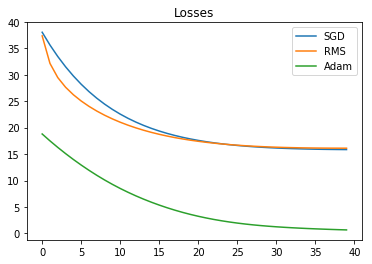

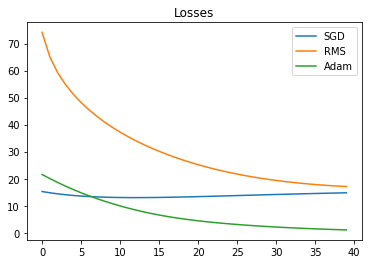

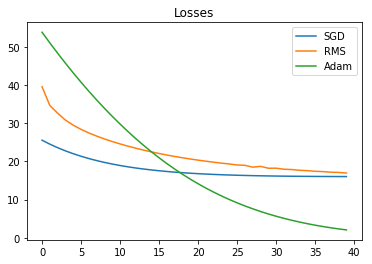

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

T = np.arange(TRAINING_STEPS)
for _ in range(3): 
    
    sgd_losses = learn(SGD)
    rms_losses = learn(RMS)
    adam_losses = learn(Adam)
    p1, = plt.plot(T, sgd_losses, label='SGD')
    p2, = plt.plot(T, rms_losses, label='RMS')
    p3, = plt.plot(T, adam_losses, label='Adam')
    plt.legend(handles=[p1, p2, p3])
    plt.title('Losses')
    plt.show()

#### Meta-optimizer
而这些优化器的更新策略是根据人的经验主观设计，来解决一般的优化问题
而针对一个特定的优化问题，也许一个特定的优化器能够更好的优化它，我们是否可以不根据人工设计，而是让优化器本身根据模型与数据，自适应地调节，这就涉及到了meta-learning

假如一个优化器可以根据历史优化的经验来自身调解自己的优化策略，那么就一定程度上做到了自适应，这个不是说像Adam，momentum，RMSprop那样自适应地根据梯度调节学习率，（其梯度更新规则还是不变的），而是说自适应地改变其梯度更新规则，而Learning to learn 这篇论文就使用LSTM（RNN）优化器做到了这一点，毕竟RNN存在一个可以保存历史信息的隐状态。

In [ ]:
Layers = 2
Hidden_nums = 20
Input_DIM = DIM
Output_DIM = DIM
# "coordinate-wise" RNN 
LSTM=torch.nn.LSTM(Input_DIM,Output_DIM ,Layers)
batchsize = 1

def LSTM_Optimizer(gradients, state):
    
    #LSTM的输入为梯度，pytorch要求torch.nn.lstm的输入为（1，batchsize,input_dim）
    #原gradient.size()=torch.size[5] ->[1,1,5]
    gradients = gradients.unsqueeze(0).unsqueeze(0)
 
    if state is None:
        state = (torch.randn(Layers,batchsize,Output_DIM),
                 torch.randn(Layers,batchsize,Output_DIM))
    
    update, state = LSTM(gradients, state)
    
    # Squeeze to make it a single batch again.[1,1,5]->[5]
    return update.squeeze().squeeze(), state

从上面LSTM优化器的设计来看，我们几乎没有加入任何先验的人为经验在里面，只是用了长短期记忆神经网络的架构，优化器本身的参数即LSTM的参数，然后这个优化器的参数代表了我们的更新策略，后面我们会学习这个参数，即学习用什么样的更新策略，即learning to learn.

对了如果你不太了解LSTM的话，我就放这个网站http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 博客的几个图，它很好解释了什么是RNN和LSTM：

<center><img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="300"></center>
<center><img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png" width="300"> </center>
<center><img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png" width="300"> </center>
<center><img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png" width="300"> </center>
<center><img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" width="300"> </center>
<center><img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" width="300"> </center>

好了，看一下我们使用LSTM后的结果

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

x = np.arange(TRAINING_STEPS)
for _ in range(3): 
    
    sgd_losses = learn(SGD)
    rms_losses = learn(RMS)
    adam_losses = learn(Adam)
    lstm_losses= learn(LSTM_Optimizer)
    p1, = plt.plot(x, sgd_losses, label='SGD')
    p2, = plt.plot(x, rms_losses, label='RMS')
    p3, = plt.plot(x, adam_losses, label='Adam')
    p4, = plt.plot(x, lstm_losses, label='LSTM')
    plt.legend(handles=[p1, p2, p3, p4])
    plt.title('Losses')
    plt.show()

#### 咦，为什么LSTM优化器那么差？

##### 先别着急质疑！
因为我们还没有学习LSTM的参数，用到的LSTM模型完全是随机初始化的！并且LSTM的参数在TRAIN_STEPS=[0,T]中的每个节点都是保持不变的！

下面我们就来优化LSTM的参数！

不论是原始优化问题，还是隶属元学习的LSTM优化目标，我们都一个共同的学习目标：

$$\theta ^{*}= \arg\min_{\theta\in \Theta }f\left ( \theta  \right )$$

或者说我们希望迭代后的loss值变得很小，传统方法，是基于每个迭代周期，一步一步，让loss值变小，可以说，传统优化器进行梯度下降时所站的视角是在某个周期下的，那么，我们其实可以换一个视角，更全局的视角，即，我们希望所有周期迭代的loss值都很小，这和传统优化是不违背的，并且是全局的：

- Meta-optimizer优化：“所有周期的loss都要很小！”
- 传统优化器："只要这一步的loss比上一步的loss值要小就行”

接下来我们就站在更全局的角度，来优化LSTM优化器的参数，LSTM是循环神经网络，它可以连续记录并传递所有周期时刻的信息，其每个周期循环里的子图共同构建一个巨大的图，然后使用Back-Propagation Through Time (BPTT)来求导更新

In [ ]:
lstm_losses= learn(LSTM_Optimizer) # [loss1,loss2,...lossT] 所有周期的loss
all_computing_graph_loss = torch.tensor(lstm_losses).sum() 
#构建一个所有周期子图构成的总计算图,使用BPTT来梯度更新LSTM参数

print(all_computing_graph_loss )

下面针对LSTM的参数进行全局优化。
这里值得说明一下：这里LSTM优化后的参数，是在所有TRAIN_STEPS=[0,T]中保持不变的,这也就是论文里面提到的coordinate-wise，即“对每个时刻点都保持‘全局聪明’”，即学习到LSTM的参数是全局最优的了。因为我们是站在所有TRAIN_STEPS=[0,T]的视角下进行的优化！这里优化器选择的是Adam优化器，进行梯度下降

In [ ]:
def learning_to_learn___optimizer_master(global_loss):
    
    adam_global_optimizer = torch.optim.Adam()
    
Global_Train_Steps = 40
